## Trip Lab notebook
Predict when the driver will arrive at the pick up location before the driver has started driving there. 
What factors are most predictive of lateness?


In [1]:
import pandas as pd
import numpy as np

In [2]:
dateColNames=['canceled_at_pdt', 'claimed_at_pdt', 'departs_for_trip_at_pdt',
       'created_at_pdt', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt',
       'origin_arrived_at_pdt', 'origin_departed_at_pdt',
       'destination_arrived_at_pdt', 'lead_organizer_created_at_pdt',
       'driver_created_at_pdt']

In [3]:
df=pd.read_csv('/Users/bob 2/Projects/TripsData2017.txt', sep='\t', parse_dates=dateColNames)

In [4]:
df.shape

(217348, 74)

In [5]:
list(df)

['id',
 'trip_state',
 'canceled_by',
 'canceled_at_pdt',
 'canceled_before_scheduled_start',
 'claimed_at_pdt',
 'driver_id',
 'lead_organizer_id',
 'creator_id',
 'carpool',
 'is_repeating_ride',
 'shuttle',
 'trip_template_id',
 'departs_for_trip_at_pdt',
 'time_anchor',
 'created_at_pdt',
 'scheduled_starts_at_pdt',
 'scheduled_ends_at_pdt',
 'origin_arrived_at_pdt',
 'origin_departed_at_pdt',
 'destination_arrived_at_pdt',
 'origin_location_id',
 'destination_location_id',
 'origin_region_id',
 'origin_analysis_metro_name',
 'destination_region_id',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'origin_lat',
 'origin_lon',
 'destination_lat',
 'destination_lon',
 'passengers_ids',
 'organizers_count',
 'passengers_count',
 'driver_home_lat',
 'driver_home_lon',
 'organizer_home_lat',
 'organizer_home_lon',
 'rating',
 'canceled_by_id',
 'route_legs_count',
 'start_waypoints_zipcode

In [6]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217348 entries, 0 to 217347
Columns: 74 entries, id to driver_has_driven_this_route_before
dtypes: bool(8), datetime64[ns](11), float64(29), int64(5), object(21)
memory usage: 111.1+ MB


In [7]:
df.info

<bound method DataFrame.info of             id trip_state canceled_by     canceled_at_pdt  \
0       367322   canceled    Employee 2017-03-08 13:18:55   
1       492666   canceled    Employee 2017-09-11 09:09:43   
2       527985   canceled    Employee 2017-09-27 14:02:52   
3       415557   canceled    Employee 2017-05-22 13:47:32   
4       317210   canceled    Employee 2017-01-18 10:14:22   
5       338150   complete         NaN                 NaT   
6       310958   complete         NaN                 NaT   
7       338135   complete         NaN                 NaT   
8       324615   complete         NaN                 NaT   
9       247127   complete         NaN                 NaT   
10      306833   complete         NaN                 NaT   
11      436184   complete         NaN                 NaT   
12      473473   complete         NaN                 NaT   
13      354050   complete         NaN                 NaT   
14      415507   complete         NaN                

#### columns_from_the_future must not be used in predictions but some are needed to label the data

In [8]:
columns_from_the_future = ['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
print(columns_from_the_future)
print(len(columns_from_the_future))

['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
18


In [9]:
list(df.select_dtypes(['object']).columns)

['trip_state',
 'canceled_by',
 'time_anchor',
 'origin_analysis_metro_name',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'passengers_ids',
 'rating',
 'start_waypoints_zipcodes',
 'end_waypoints_zipcodes',
 'lead_organizer_platform',
 'lead_organizer_app_version',
 'driver_platform',
 'driver_app_version',
 'driver_gender',
 'coupon',
 'events',
 'has_cd_unclaimed_event']

In [10]:
df.dtypes

id                                                  int64
trip_state                                         object
canceled_by                                        object
canceled_at_pdt                            datetime64[ns]
canceled_before_scheduled_start                   float64
claimed_at_pdt                             datetime64[ns]
driver_id                                         float64
lead_organizer_id                                   int64
creator_id                                          int64
carpool                                              bool
is_repeating_ride                                    bool
shuttle                                              bool
trip_template_id                                  float64
departs_for_trip_at_pdt                    datetime64[ns]
time_anchor                                        object
created_at_pdt                             datetime64[ns]
scheduled_starts_at_pdt                    datetime64[ns]
scheduled_ends

#### pick features to use as input to prediction. here just numerics and not those from the future.
todo: add booleans, date features, object features as categorical dummies

In [11]:
feature_columns_to_use=list(set(df.select_dtypes(include=['number']).columns) - set(columns_from_the_future))
print(feature_columns_to_use)

['total_predicted_distance_miles', 'lead_organizer_previous_completed_trips', 'total_predicted_duration', 'predicted_driver_fare', 'organizer_home_lat', 'destination_lat', 'driver_previous_completed_trips', 'destination_region_id', 'coupon_consumed', 'id', 'creator_id', 'driver_id', 'organizers_count', 'destination_location_id', 'origin_location_id', 'origin_region_id', 'lead_organizer_id', 'trip_predicted_raw_fare', 'driver_home_lon', 'passengers_count', 'origin_lon', 'organizer_home_lon', 'trip_template_id', 'origin_lat', 'claimed_after_created', 'destination_lon', 'driver_home_lat', 'route_legs_count']


#### compute arrived_late label, ah should be 5 min late. At 0 seconds, 9% of trips are "late"!

In [12]:
arrival_time_df=df[['id','scheduled_starts_at_pdt','origin_arrived_at_pdt']]
arrival_time_df.shape
arrival_time_df=arrival_time_df.assign(
    arrived_seconds_after_scheduled_start=lambda x:
        (x['origin_arrived_at_pdt'] - x['scheduled_starts_at_pdt']).dt.total_seconds()
)

# show number of nulls
arrival_time_df.isnull().sum()



id                                           0
scheduled_starts_at_pdt                      0
origin_arrived_at_pdt                    91673
arrived_seconds_after_scheduled_start    91673
dtype: int64

In [13]:
arrival_time_df.dropna().shape


(125675, 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112c8ed30>]],
      dtype=object)

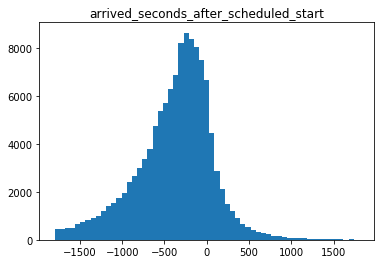

In [35]:
arrival_time_df.dropna().hist(column='arrived_seconds_after_scheduled_start',bins=np.linspace(-1800,1800,60),grid=False)


In [15]:
# arrives 8.5 minutes early on average
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mean()/60

arrived_seconds_after_scheduled_start   -8.456539
dtype: float64

In [16]:
# most often arrives 4.5 minutes early on average
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mode()/60

,arrived_seconds_after_scheduled_start
0,-4.45


In [17]:
# show rows and label to verify logic
# arrived_late_df[arrived_late_df['label']].head # version where label is TRUE
arrival_time_df.head

<bound method NDFrame.head of             id scheduled_starts_at_pdt origin_arrived_at_pdt  \
0       367322     2017-03-09 08:00:00                   NaT   
1       492666     2017-09-11 10:00:00                   NaT   
2       527985     2017-09-27 15:07:00                   NaT   
3       415557     2017-05-22 21:16:00                   NaT   
4       317210     2017-01-22 10:00:00                   NaT   
5       338150     2017-02-14 16:00:00   2017-02-14 15:51:43   
6       310958     2017-01-24 16:20:00   2017-01-24 16:20:05   
7       338135     2017-02-08 16:00:00   2017-02-08 15:54:47   
8       324615     2017-01-26 16:30:00   2017-01-26 16:25:04   
9       247127     2017-01-23 14:45:00   2017-01-23 14:42:14   
10      306833     2017-01-11 14:25:00   2017-01-11 14:20:23   
11      436184     2017-06-26 13:30:00   2017-06-26 13:15:40   
12      473473     2017-08-21 14:30:00   2017-08-21 14:10:25   
13      354050     2017-02-27 15:00:00   2017-02-27 14:48:47   
14      41

In [18]:
# features look ok, contain some NaNs
df[feature_columns_to_use].head

<bound method NDFrame.head of         total_predicted_distance_miles  \
0                                  1.0   
1                                  0.0   
2                                  0.0   
3                                  9.0   
4                                  2.0   
5                                 10.0   
6                                  5.0   
7                                  5.0   
8                                  7.0   
9                                 13.0   
10                                 1.0   
11                                11.0   
12                                 2.0   
13                                 2.0   
14                                 4.0   
15                                 3.0   
16                                 3.0   
17                                 3.0   
18                                 3.0   
19                                 7.0   
20                                 7.0   
21                                 2.0   
22  

In [19]:
# hmmm too many NaNs
df[feature_columns_to_use].dropna().shape

(64, 28)

In [20]:
# replace NaNs with 0s, although another solution for missing latlons is probably better
df[feature_columns_to_use].fillna(0).shape

(217348, 28)

In [21]:
# eliminate rows where on-time arrival cannot be computed (canceled before arrival, possibly filled).
df.loc[df['origin_arrived_at_pdt'].notnull()].shape

(125675, 74)

In [22]:
# how many observations of each final state do we have left where on-time arrival can be labeled
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state']).size()

trip_state
canceled      1529
complete    124146
dtype: int64

In [23]:
# how many are filled; all should be but 1 wierd trip arrived with no driver! 
# chaotic race condition when scheduled start time approaching, cancel by organizer, removing driver, and driver arriving 
# It will be filled with 0 which is ok.
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state',df.driver_id.notnull()]).size()

trip_state  driver_id
canceled    False             1
            True           1528
complete    True         124146
dtype: int64

In [24]:
# materialize the useful dataset for training and testing
df_X=df.loc[df['origin_arrived_at_pdt'].notnull()][feature_columns_to_use].fillna(0)
df_X.shape

(125675, 28)

In [25]:
# materialize the prediction target (arrived_seconds_after_scheduled_start)
y=(df.loc[df['origin_arrived_at_pdt'].notnull()].origin_arrived_at_pdt 
   - df.loc[df['origin_arrived_at_pdt'].notnull()].scheduled_starts_at_pdt).dt.total_seconds()

# describe and convert from scientific notation
y.describe().apply(lambda x: '%.0f' % x)

count      125675
mean         -507
std         22763
min      -7862491
25%          -657
50%          -324
75%           -96
max        204537
dtype: object

In [26]:
# write out features (df_X) and targets (y) into files
fileprefix='./lateness_PREP_V1_'
df_X.to_csv(fileprefix+'X.csv', sep='\t')


In [32]:
y.to_csv(path=fileprefix+'y.csv', sep='\t')

In [33]:
y.shape

(125675,)

In [34]:
y.head()

5   -497.0
6      5.0
7   -313.0
8   -296.0
9   -166.0
dtype: float64